<a href="https://colab.research.google.com/github/andr3w1699/Intelligent_System_for_Pattern_Recognition/blob/main/SecondAssignement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Second assignement ISPR: ANDREA LEPORI

Selected assignement:

Assignment 3

Implement from scratch an RBM and apply it to DSET2. The RBM should be implemented fully by you (both training and inference steps) but you are free to use library functions for the rest (e.g. image loading and management, etc.). Implement a generalization of the Contrastive Divergence (CD) learning algorithm that defines the number of steps K of the Gibbs sampling Markov chain runned before collecting the samples to estimate the model expectation. For instance the standard CD learning would be obtained with K=1. Test your models by training two versions of them, one with a small K and one with a medium K (I suggest you do not go over 10 steps), and discuss the differences in performance/behaviour (if any).

Outline of the assigment:

1.     Train an RBM with a number of hidden neurons selected by you (single layer) on the MNIST data (use the training set split provided by the website) using CD(K) with two choices of K.

2.     Use the trained RBMs to encode a selection of test images (e.g. using one per digit type) using the corresponding activation of the hidden neurons.

3.    Train a simple classifier (e.g. any simple classifier in scikit) to recognize the MNIST digits using as inputs their encoding obtained at step 2. Use the standard training/test split. Show a performance metric of your choice in the presentation/handout and use it to confront the two versions of the RBM (obtained with different K).

Dataset:
DSET2 (Image processing: MNIST): (https://www.kaggle.com/datasets/hojjatk/mnist-dataset) or (https://huggingface.co/datasets/ylecun/mnist/) or (http://yann.lecun.com/exdb/mnist/)


In [1]:
!pip install numpy torch scikit-learn matplotlib torchvision

In [2]:
# import libraries
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
import math

In [3]:
# Load MNIST Dataset

# This defines how each image in the dataset should be preprocessed before being used.
# transforms.ToTensor() converts each image (which is in PIL Image format) into a PyTorch tensor with values scaled between 0 and 1.
# transforms.Compose([...]) lets you chain multiple transforms together, though here we’re just using one (ToTensor()).
transform = transforms.Compose([transforms.ToTensor()])

# download and store the training and test portion of the MNIST dataset
# The dataset will be stored in a folder called data in your project directory.
# train=True --> training, train=False --> test set.
# download=True: Downloads the dataset automatically if it's not already there.
# transform=transform: Applies the ToTensor() transform to each image when it's loaded.
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Wraps the dataset in a DataLoader, which is an iterator that loads the data in batches.
# batch_size=64: Each time you ask for a batch, it gives you 64 images (and their labels).
# shuffle=True: Randomly shuffles the dataset each epoch, which helps make training more effective (less bias from order).
# Hinton suggests minibatch size of 10 when training an RBM
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
# same idea, but for the test set, fetches larger batches for faster evaluation (you don't need to update weights during testing).
# shuffle=False: We don’t shuffle the test set — it’s okay to evaluate in order.
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)


Batch shape: torch.Size([10, 1, 28, 28])
Label shape: torch.Size([10])


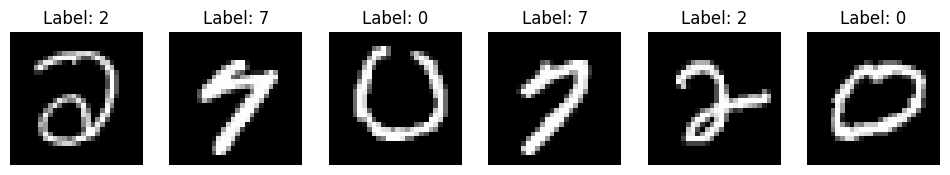

In [4]:
# Get one batch from the train_loader
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show the shape
print(f"Batch shape: {images.shape}")      # (batch_size, 1, 28, 28)
print(f"Label shape: {labels.shape}")      # (batch_size,)

# Show the first 6 images with labels
fig, axes = plt.subplots(1, 6, figsize=(12, 2))
for i in range(6):
    img = images[i].squeeze()  # Remove channel dimension (1,28,28) -> (28,28)
    label = labels[i].item()
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f"Label: {label}")
    axes[i].axis('off')

plt.show()

# Understanding image representation:

`images.shape` → `(64, 1, 28, 28)`

*   64 images in this batch
*   Each image has 1 channel (grayscale)
*   Each image is 28x28 pixels
*   Pixel values are in the range [0, 1] (because of ToTensor())
*   Each image is stored as a PyTorch tensor




In [5]:
# to see the raw tensor (pixel values):
print(images[0])               # Tensor of shape (1, 28, 28)

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [6]:
print(images[0][0])            # First channel (since it's grayscale, just one)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

In [7]:
print(images[0][0][:5, :5])    # Top-left 5x5 corner pixel values

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])


# RBM Implementation (from scratch)

Here I provide a basic implementation of RBM, to the standard implementation some additional options have been added such as regularization with weight decay (L2 norm), momentum, penalty to enforce the sparsity of hidden features, according to the suggestions in the following Hinton paper. Also some choices of initialization of hyperparameters and setting of the minibatch size are due to the following paper.

A Practical Guide to Training Restricted Boltzmann Machines, Geoffrey Hinton : https://www.cs.toronto.edu/~hinton/absps/guideTR.pdf



## A Note on the derivation of Bias learning update:

### 1 Objective Function (Negative Log-Likelihood)

We want to maximize the log-likelihood of the data:

$$
\log P(v) = \log \sum_h e^{-E(v, h)} - \log Z
$$

Where:
- \( E(v, h) \): Energy function  
- \( Z \): Partition function (hard to compute exactly)

---

### 2. Gradient of Log-Likelihood (with respect to bias)

#### For the visible bias \( b_i \):

$$
\frac{\partial \log P(v)}{\partial b_i} = \mathbb{E}_{\text{data}}[v_i] - \mathbb{E}_{\text{model}}[v_i]
$$

#### For the hidden bias \( c_j \):

$$
\frac{\partial \log P(v)}{\partial c_j} = \mathbb{E}_{\text{data}}[h_j] - \mathbb{E}_{\text{model}}[h_j]
$$

**Interpretation**:
- **Data expectation**: What the bias "should" be based on real input  
- **Model expectation**: What the model thinks it should be (after reconstruction)

---

### 3. Contrastive Divergence Approximation

Since computing the model expectations is intractable, we use **Contrastive Divergence (CD-k)** to approximate them:

- **Positive phase**: Sample from real data  
- **Negative phase**: Sample from the model (after \( k \) Gibbs steps)

#### Bias update rules:

- **Visible bias update**:

$$
\Delta b_i \propto \langle v_i^{(0)} \rangle - \langle v_i^{(k)} \rangle
$$

- **Hidden bias update**:

$$
\Delta c_j \propto \langle h_j^{(0)} \rangle - \langle h_j^{(k)} \rangle
$$

Where:
- \( v^{(0)} \): visible units from real data  
- \( v^{(k)} \): reconstructed visible units after \( k \) Gibbs steps  
- \( h^{(0)}, h^{(k)} \): hidden units corresponding to those visible units


In [8]:
class RBM:
  def __init__(self, n_visible, n_hidden, k=1, learning_rate=0.001, weight_cost=0.0001, sparsity_target=0.05, sparsity_cost=0.0001, sparsity_decay=0.9):
    # number of input neurons (in MNIST pixels of an image --> 28x28 = 784)
    self.n_visible = n_visible
    # number of hidden units (it's an hyperparameter)
    self.n_hidden = n_hidden
    # number of Gibbs sampling steps for Contrastive Divergence (CD-k).
    self.k = k
    # step size for updating the weights and biases.
    self.learning_rate = learning_rate

    # W is the weight matrix connecting visible to hidden units.
    # Shape = n_hidden x n_visible. Initialized to Random small values
    self.W = torch.randn(n_hidden, n_visible) * 0.01  # weight matrix
    self.h_bias = torch.zeros(n_hidden)               # hidden bias
    self.v_bias = torch.zeros(n_visible)              # visible bias

    # Initialize momentum terms (used to stabilize updates and help convergence during training)
    self.W_momentum = torch.zeros_like(self.W)
    self.h_bias_momentum = torch.zeros_like(self.h_bias)
    self.v_bias_momentum = torch.zeros_like(self.v_bias)

    # Initialize regularization coefficient
    self.weight_cost = weight_cost

    # Initialize sparsity params. q tracks running average activation of each hidden unit
    self.sparsity_target = sparsity_target  # desired probability of activation of each hidden unit
    self.sparsity_cost = sparsity_cost    # sparsity penalization coefficient
    self.sparsity_decay = sparsity_decay  # coefficient used to weight the running average
    self.q = torch.zeros(n_hidden)  # running estimate of q for each hidden unit


  # Sample hidden units given visible units
  # params: v is a batch of visible units
  def sample_h(self, v):
        # computes wx (pre-activation or net) that is the weighthed sum + bias for hidden units
        wx = torch.matmul(v, self.W.t()) + self.h_bias
        # computes probability of activation
        prob = torch.sigmoid(wx)
        # returns probabilities and sampled binary activations (0 or 1)
        return prob, torch.bernoulli(prob)

  # Sample visible units given hidden units
  # Reverse of sample_h. Given hidden units, reconstruct visible units
  # Returns probabilities + samples for visible layer
  def sample_v(self, h):
        wx = torch.matmul(h, self.W) + self.v_bias
        prob = torch.sigmoid(wx)
        return prob, torch.bernoulli(prob)

  # CD-k Training Step
  # Performs CD-k to update weights and biases based on the difference between real data and model-generated data.
  def contrastive_divergence(self, v0, momentum=0.0):
        # start with input v0 (original data/training example)
        v = v0
        # run k steps of Gibbs sampling
        # sample h from v, then v from h, repeatedly
        # this gives the model's approximation of the input data (its "fantasy" or "dream")
        for _ in range(self.k):
            ph, h = self.sample_h(v)
            pv, v = self.sample_v(h)

        # Positive and negative phases
        # positive phase: compute hidden activations from original input
        ph0, h0 = self.sample_h(v0)
        # negative phase: compute hidden activations from model-generated (sampled) input after k steps.
        phk, hk = self.sample_h(v)

        # Update weights and biases using the difference between positive and negative phases
        # intuition: update weights and biases using the difference between positive and negative phases
        # self.W += self.learning_rate * (torch.matmul(h0.t(), v0) - torch.matmul(hk.t(), v))
        # self.v_bias += self.learning_rate * torch.sum(v0 - v, dim=0)
        # self.h_bias += self.learning_rate * torch.sum(h0 - hk, dim=0)

        # get batch size = num of elem in the batch to implement gradient averaging
        batch_size = v0.size(0)
        # dW: weight update = data-driven term − model-driven term − weight decay
        dW = (torch.matmul(h0.t(), v0) - torch.matmul(hk.t(), v)) / batch_size
        dW -= self.weight_cost * self.W  # <-- L2 regularization on weights
        # bias updates see the note above to see why is like this
        dvb = torch.sum(v0 - v, dim=0) / batch_size
        dhb = torch.sum(h0 - hk, dim=0) / batch_size


        # Sparsity regularization:
        # Keeps average activation of hidden units near a target (sparsity_target)
        # Penalizes deviation via sparsity_cost
        if self.sparsity_cost != 0:
          # Update q (running estimate of hidden unit activity)
          q_current = torch.mean(ph0, dim=0)  # mean activation over batch
          self.q = self.sparsity_decay * self.q + (1 - self.sparsity_decay) * q_current

          # Sparsity gradient (q - p)
          sparsity_grad = self.q - self.sparsity_target  # shape: [n_hidden]

          # Expand to match W shape: each row in W corresponds to one hidden unit
          sparsity_grad_matrix = sparsity_grad.view(-1, 1)  # shape: [n_hidden, 1]

          # Apply sparsity cost to weight gradient and hidden bias gradient
          # This broadcasts the [nhidden,1] matrix across all columns of dW,
          # so each hidden unit's sparsity gradient is applied across all its connections to visible units, which is correct.
          dW -= self.sparsity_cost * sparsity_grad_matrix
          # adjust the hidden bias update with the sparsity gradient
          dhb -= self.sparsity_cost * sparsity_grad

        # Apply momentum update
        self.W_momentum = momentum * self.W_momentum + self.learning_rate * dW
        self.v_bias_momentum = momentum * self.v_bias_momentum + self.learning_rate * dvb
        self.h_bias_momentum = momentum * self.h_bias_momentum + self.learning_rate * dhb

        # Apply params update
        self.W += self.W_momentum
        self.v_bias += self.v_bias_momentum
        self.h_bias += self.h_bias_momentum

  # Computes the empirical activation probabilities of visible units in the training set, then set initial visible bias accordingly
  def initialize_visible_bias(self, train_loader):
        """
        Estimate p_i (activation probability) for each visible unit and set visible bias accordingly.
        """
        total = 0 # keeps track of the total number of samples seen
        sum_activations = torch.zeros(self.n_visible) # will accumulate the total number of times each visible unit (pixel) is active (i.e., ≥ 0.5) across the dataset

        # looping thorugh mini-batches of training data
        for batch, _ in train_loader:
            batch = batch.view(-1, self.n_visible) # flattens each image (e.g., from [B, 1, 28, 28] → [B, 784])
            batch = (batch > 0.5).float() # binarizes the data (pixel active if value > 0.5) and converts boolean to 0.0 or 1.0
            sum_activations += torch.sum(batch, dim=0) # counts how many times each pixel is on in the batch and accumulates activations over all batches
            total += batch.size(0) # adds number of samples in the batch

        pi = sum_activations / total # empirical probability pi​ that each visible unit is active over the entire dataset
        pi = torch.clamp(pi, min=1e-5, max=1 - 1e-5)  # avoid log(0) --> clamps the values to avoid numerical issues

        # Sets the initial visible bias bibi​ using the logit function:
        # bi = log(pi/(1-pi))
        # This ensures that, before training, each visible unit's activation probability under the model roughly matches the empirical data distribution
        # (i.e., if pixel 42 is usually on 70% of the time, this makes the model initially behave that way too).
        self.v_bias = torch.log(pi / (1 - pi))

  # Training loop: trains the RBM over n_epochs
  def train(self, train_loader, use_momentum=True, n_epochs=5):
    # smart initialization of visible bias as suggested by Hinton this speed up the training
    self.initialize_visible_bias(train_loader)

    # start with low momentum then increase it later
    momentum = 0.5
    # loss at previous epoch
    prev_loss = float('inf')
    # take one-third of the total number of training epochs
    trigger_epoch = n_epochs // 3  # when to switch to higher momentum

    # traininig loop on binarized images, run for n_epochs total epochs
    for epoch in range(n_epochs):
        loss = 0 # reinitialize the cumulative loss for this epoch
        for images, _ in train_loader: #  Iterate over batches of images from the train_loader, ignore the labels (not used in RBM)
            images = images.view(-1, self.n_visible) # Reshape the batch of images from [batch_size, 1, 28, 28] to [batch_size, 784]. This flattens each image into a 1D vector of pixels.
            images = (images > 0.5).float() # Binarize the images: pixels > 0.5 are set to 1.0, others to 0.0
            # Run Contrastive Divergence training step using the input batch
            self.contrastive_divergence(images, momentum=momentum if use_momentum else 0.0)
            # compute reconstruction loss (MSE between input and its reconstruction)
            # self.reconstruct(images) returns the model's attempt to reconstruct the original batch
            # We calculate the mean squared error (original - reconstruction)^2 and accumulate it over the epoch
            loss += torch.mean((images - self.reconstruct(images)) ** 2).item()

        # compute the average reconstruction loss over all batches in the epoch.
        avg_loss = loss / len(train_loader)
        # Print useful diagnostic
        print(f"Epoch {epoch + 1}, Loss: {avg_loss:.6f}, Momentum: {momentum:.2f}, LR: {self.learning_rate:.6f}, WC: {self.weight_cost:.6f}")

        # Momentum scheduling:
        # After one-third of training, increase momentum to 0.9, this helps speed up convergence after the model starts to stabilize
        if use_momentum and epoch == trigger_epoch:
            print("↑ Increasing momentum to 0.9")
            momentum = 0.9

        # Instability detection: if error increases a lot
        # If loss increases more than 20% compared to previous epoch:
        #                   - Learning rate is halved
        #                   - Momentum is reset to 0.5 for more stability
        if use_momentum and epoch > trigger_epoch and avg_loss > prev_loss * 1.2:
            print("⚠️ Instability detected. Reducing learning rate by 2.")
            self.learning_rate /= 2
            momentum = 0.5  # Reset momentum if needed
            print(f"New learning rate: {self.learning_rate:.6f}")

        # Save current epoch's loss to compare with the next one.
        prev_loss = avg_loss

  # Rebuild Input:
  # Reconstructs visible units from hidden units
  # Returns: probabilities not samples
  def reconstruct(self, v):
      # visible --> hidden
      prob_h, h = self.sample_h(v)
      # hidden --> visible
      prob_v, v_sample = self.sample_v(prob_h)
      return prob_v

  # Encoding Input:
  # Encode/Embed visible data in the hidden features
  # Return probabilities
  def encode(self, v):
      prob_h, _ = self.sample_h(v)
      return prob_h

  # This method is meant to visualize the features learned by the hidden units in the RBM, by showing the weights of each hidden unit as an image.
  # This useful visualization that helps you to make sense of what's going on during your training is suggested by Hinton in his paper
  def show_learnt_features(self, num_features=100):
    """
    Visualize learned features (rows of weight matrix) as 28x28 images.
    """
    # Makes sure you don’t try to visualize more features than there are hidden units.
    # Clamp number of features to number of hidden units
    num_features = min(num_features, self.n_hidden)
    # Decides how to arrange the feature visualizations in a square grid
    # If you have 100 features, this makes a 10×10 grid.
    # If you have 50 features, it makes an 8×8 grid (with some empty spots).
    grid_size = int(np.ceil(np.sqrt(num_features)))

    fig, axes = plt.subplots(grid_size, grid_size, figsize=(8, 8))
    for idx in range(num_features):
        row = idx // grid_size
        col = idx % grid_size
        ax = axes[row, col]
        # self.W[idx] is the weights from hidden unit idx to all visible units (i.e., the image pixels).
        # We reshape it to 28x28, which is the size of the original images (like MNIST).
        # detach().numpy() converts it from a PyTorch tensor to a NumPy array for plotting.
        weight_img = self.W[idx].detach().numpy().reshape(28, 28)
        # Displays the reshaped weight image as a grayscale image.
        # The intensity of each pixel shows how strongly it's connected to that hidden unit.
        ax.imshow(weight_img, cmap='gray')
        ax.axis('off')

    # If the grid has more cells than features, this hides the extra empty plots.
    # For example, if you asked for 50 features but the grid is 8×8 (64 cells), this hides the last 14.
    for i in range(num_features, grid_size * grid_size):
        axes[i // grid_size, i % grid_size].axis('off')

    plt.suptitle("Learned Features", fontsize='x-large')
    plt.tight_layout()
    plt.show()

Epoch 1, Loss: 0.054974, Momentum: 0.50, LR: 0.001000, WC: 0.000100
↑ Increasing momentum to 0.9
Epoch 2, Loss: 0.026312, Momentum: 0.90, LR: 0.001000, WC: 0.000100


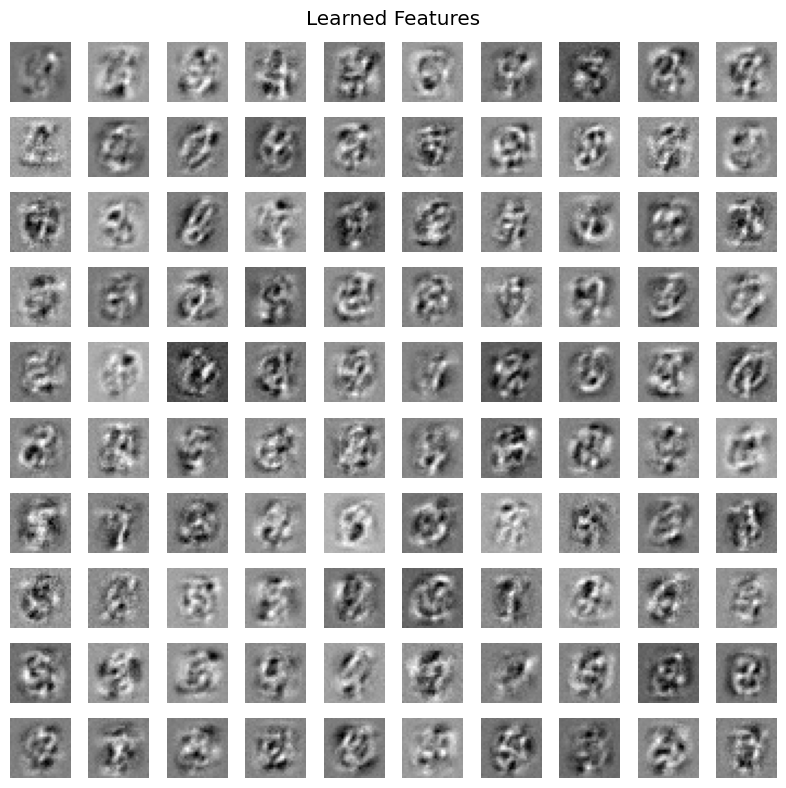

Epoch 1, Loss: 0.054508, Momentum: 0.50, LR: 0.001000, WC: 0.000100
↑ Increasing momentum to 0.9
Epoch 2, Loss: 0.025452, Momentum: 0.90, LR: 0.001000, WC: 0.000100


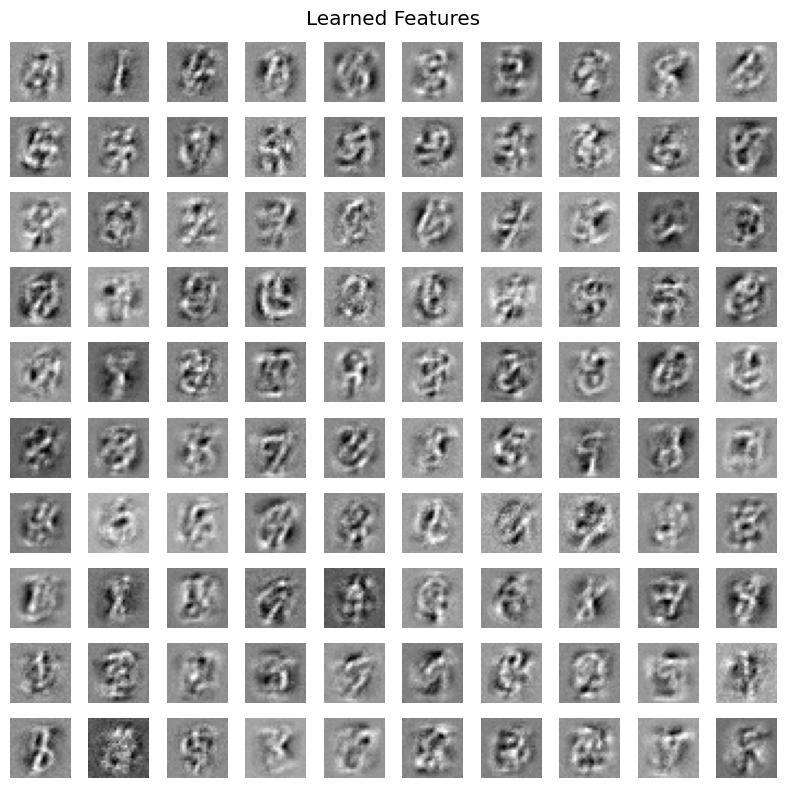

In [9]:
# set the number of visible units (This is dictated by the number of pixels in the image) and the number of hidde units (model selection choice)
n_visible = 28 * 28
n_hidden = 1024 # or 512

# RBM with K=1
rbm_k1 = RBM(n_visible=n_visible, n_hidden=n_hidden, k=1)
rbm_k1.train(train_loader, n_epochs=2)
rbm_k1.show_learnt_features()

# RBM with K=5
rbm_k5 = RBM(n_visible=n_visible, n_hidden=n_hidden, k=5)
rbm_k5.train(train_loader, n_epochs=2)
rbm_k5.show_learnt_features()

In [10]:
# This is a function that takes a trained rbm model, take a data_loader (like train_loader or test_loader)
# Return the encoded hidden layer activations (i.e., features) and their corresponding labels
def get_encoded_features(rbm, data_loader):
    features = [] #  the encoded outputs (from hidden layer)
    labels = [] # the actual class labels (like digits in MNIST)
    # This line tells PyTorch: don’t track gradients, because we’re just doing inference (no training). It saves memory and speeds things up.
    with torch.no_grad():
        # Iterates through batches of data from the loader. images are the input samples, and targets are the corresponding class labels.
        for images, targets in data_loader:
            # linearize/vectorize images
            images = images.view(-1, 28*28)
            # binarize images
            images = (images > 0.5).float()
            # Passes the binarized input to the RBM’s hidden layer using the encode() method
            # This computes the hidden probabilities P(h=1∣v)
            # The result is a feature vector for each input image
            encoded = rbm.encode(images)
            # Adds the batch of encoded features and labels to the respective lists, encoded.numpy() converts the tensor to NumPy format so we can concatenate later
            features.append(encoded.numpy())
            labels.append(targets.numpy())
    # After all batches are processed:
    # np.vstack(features) stacks all feature vectors vertically (like [N_samples, N_hidden])
    # np.hstack(labels) combines all labels into one long array ([N_samples])
    # Returns both as NumPy arrays.
    return np.vstack(features), np.hstack(labels)

# encode train and test set with RBM trained with 1-step Contrastive Divergence
X_train_k1, y_train_k1 = get_encoded_features(rbm_k1, train_loader)
X_test_k1, y_test_k1 = get_encoded_features(rbm_k1, test_loader)

# # encode train and test set with RBM trained with 5-step Contrastive Divergence
X_train_k5, y_train_k5 = get_encoded_features(rbm_k5, train_loader)
X_test_k5, y_test_k5 = get_encoded_features(rbm_k5, test_loader)

At this point we have a training set and a test set made of encoding of images obtained with the two different RBM and the corresponding label. To check their discriminative power we put on the top of those encodings a simple classifier a Logistic Regression model and we perform the usual pipeline: training on the training set and model assessment on the Test set. Since I am not extremely optimizing the model or perform any sort of model selection, just testing this model is working, I don't use a separate validation set, just training on the TR set and testing on TS set.

In [11]:
# --- Classifier for RBM with k=1 ---
clf_k1 = LogisticRegression(max_iter=1000)
clf_k1.fit(X_train_k1, y_train_k1)

# Predictions
train_pred_k1 = clf_k1.predict(X_train_k1)
test_pred_k1 = clf_k1.predict(X_test_k1)

# Accuracy
train_acc_k1 = accuracy_score(y_train_k1, train_pred_k1)
test_acc_k1 = accuracy_score(y_test_k1, test_pred_k1)

# --- Classifier for RBM with k=5 ---
clf_k5 = LogisticRegression(max_iter=1000)
clf_k5.fit(X_train_k5, y_train_k5)

train_pred_k5 = clf_k5.predict(X_train_k5)
test_pred_k5 = clf_k5.predict(X_test_k5)

train_acc_k5 = accuracy_score(y_train_k5, train_pred_k5)
test_acc_k5 = accuracy_score(y_test_k5, test_pred_k5)

# Print results
print(f"RBM k=1 - Train Accuracy: {train_acc_k1 * 100:.2f}% | Test Accuracy: {test_acc_k1 * 100:.2f}%")
print(f"RBM k=5 - Train Accuracy: {train_acc_k5 * 100:.2f}% | Test Accuracy: {test_acc_k5 * 100:.2f}%")

RBM k=1 - Train Accuracy: 98.63% | Test Accuracy: 97.39%
RBM k=5 - Train Accuracy: 98.86% | Test Accuracy: 97.62%


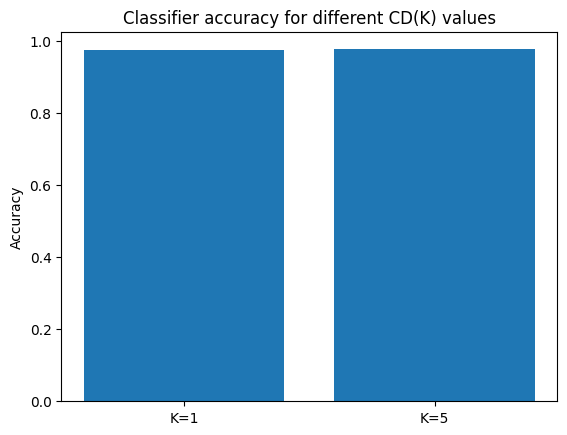

In [12]:
plt.bar(['K=1', 'K=5'], [test_acc_k1, test_acc_k5])
plt.ylabel("Accuracy")
plt.title("Classifier accuracy for different CD(K) values")
plt.show()

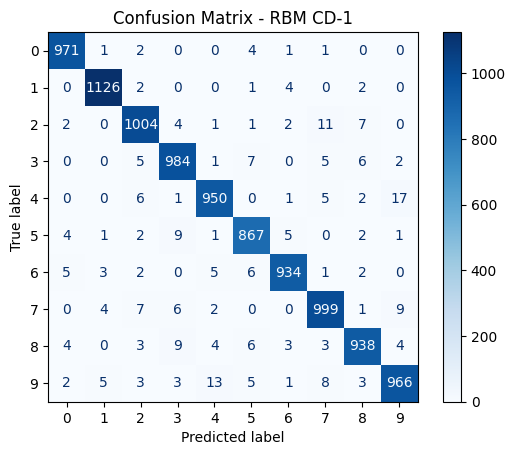

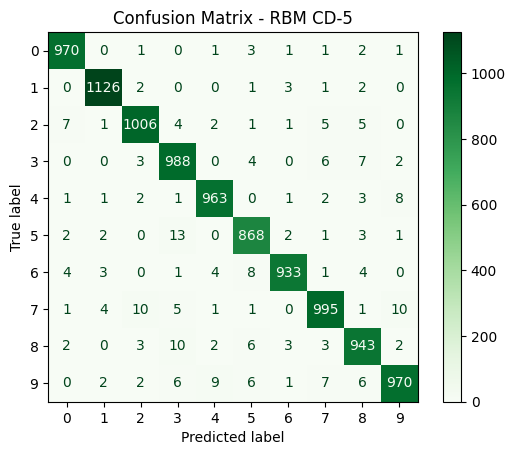

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Confusion Matrix for k=1
cm_k1 = confusion_matrix(y_test_k1, test_pred_k1)
disp_k1 = ConfusionMatrixDisplay(confusion_matrix=cm_k1)
disp_k1.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - RBM CD-1")
plt.show()

# Confusion Matrix for k=5
cm_k5 = confusion_matrix(y_test_k5, test_pred_k5)
disp_k5 = ConfusionMatrixDisplay(confusion_matrix=cm_k5)
disp_k5.plot(cmap='Greens', values_format='d')
plt.title("Confusion Matrix - RBM CD-5")
plt.show()

The two logistic regressors build respectively on the RMB trained with CD(k = 1) and on the one with CD(k = 5), achieve a classification accuracy of around 97% on the test set without having performed heavy hyperparameter optimization. This suggests that the RBM projects the visible units into hidden features with a high discriminative power, above which a simple classifier is able to achieve accuracy performances just below the state of the art (without major optimizations or model selection).

The input is projected into a space where the digits belonging to the same group are naturally separated from those belonging to other groups. In the following cells you can see the PCA or even better the t-SNE reduction of the image embeddings and how these are clustered into groups well separated from each other

No significant differences in performance are reported between the two models trained with the embeddings coming from the RBMs trained with CD(k =1) and CD(K = 5) respectively, this suggests, as expected and as expressed by Hinton in his paper, that the discriminative power of the two representations obtained is not very different, however using a single Gibbs sampling step turns out to be much more efficient than performing 5, speeding up the training of the RBM.

Performance Metric Used:
  - Accuracy (accuracy_score) is the used metric, a simple classification accuracy.
  - Confusion matrices offer deeper insight into which classes are being confused (e.g., maybe 4 is often misclassified as 9, etc.)



In [14]:
# This function is visualizing how an RBM (Restricted Boltzmann Machine) processes digit images from a dataset like MNIST. It shows three things for each digit (0–9):
#  - The original image
#  - The reconstructed image (after passing through the RBM and back)
#  - The hidden unit activations (binary vector) used during reconstruction
# rbm: the trained RBM model
# test_loader: DataLoader providing test images and labels
# n_digits: number of digits to show (defaults to 10)
def visualize_rbm_with_hidden_activations(rbm, test_loader, n_digits=10):
    # Step 1: Collect One Image per Digit (0-9)
    digit_samples = {}
    with torch.no_grad():
        for images, labels in test_loader:
            for img, lbl in zip(images, labels):
                lbl = lbl.item()
                # if have not collect yet this kind of digit ad to the collection
                if lbl not in digit_samples:
                    digit_samples[lbl] = img
                # if have 1 exampler of image for each digit stop
                if len(digit_samples) == n_digits:
                    break
            if len(digit_samples) == n_digits:
                break

    # Step 2: set up plot
    fig, axs = plt.subplots(nrows=3, ncols=n_digits, figsize=(n_digits * 1.8, 5.5))
    fig.suptitle("Original (Top), Reconstructed (Middle), Hidden Activations (Bottom)", fontsize=14)

    # Step 3: For each digit...
    for i in range(n_digits):
        # get the image for digit i
        img = digit_samples[i]
        # flatten it into a 784-dim vector
        img_flat = img.view(-1).unsqueeze(0)
        # Binarize: turns grayscale values into 0 or 1
        binary_img = (img_flat > 0.5).float()

        # Step 4: Encode and Get Hidden Activations
        # Encode to get binary sample instead of probabilities
        _, encoded = rbm.sample_h(binary_img)
        hidden_activations = encoded.squeeze().numpy()  # binary vector (0s and 1s)

        # Step 5: Make Hidden Activations Plottable
        # Dynamically reshape hidden activations into 2D grid
        hidden_size = hidden_activations.shape[0]
        grid_rows = int(math.floor(math.sqrt(hidden_size)))
        grid_cols = int(math.ceil(hidden_size / grid_rows))

        # Pad if needed
        padded = np.zeros(grid_rows * grid_cols)
        padded[:hidden_size] = hidden_activations
        hidden_img = padded.reshape((grid_rows, grid_cols))

        # Step 6: Reconstruct the image
        # Reconstructs the original image by passing it through the RBM (hidden → visible)
        # Reshapes it back to 28x28 pixels
        reconstructed = rbm.reconstruct(binary_img).view(28, 28).numpy()

        # Step 7: Plot Original, Reconstructed, and Hidden
        # Original image
        axs[0, i].imshow(img.squeeze(), cmap='gray')
        axs[0, i].axis('off')
        axs[0, i].set_title(f"Digit {i}")

        # Reconstructed image
        axs[1, i].imshow(reconstructed, cmap='gray')
        axs[1, i].axis('off')

        # Hidden activations heatmap
        axs[2, i].imshow(hidden_img, cmap='gray')  # you can try 'binary' or 'hot' too
        axs[2, i].axis('off')

    plt.tight_layout()
    plt.show()

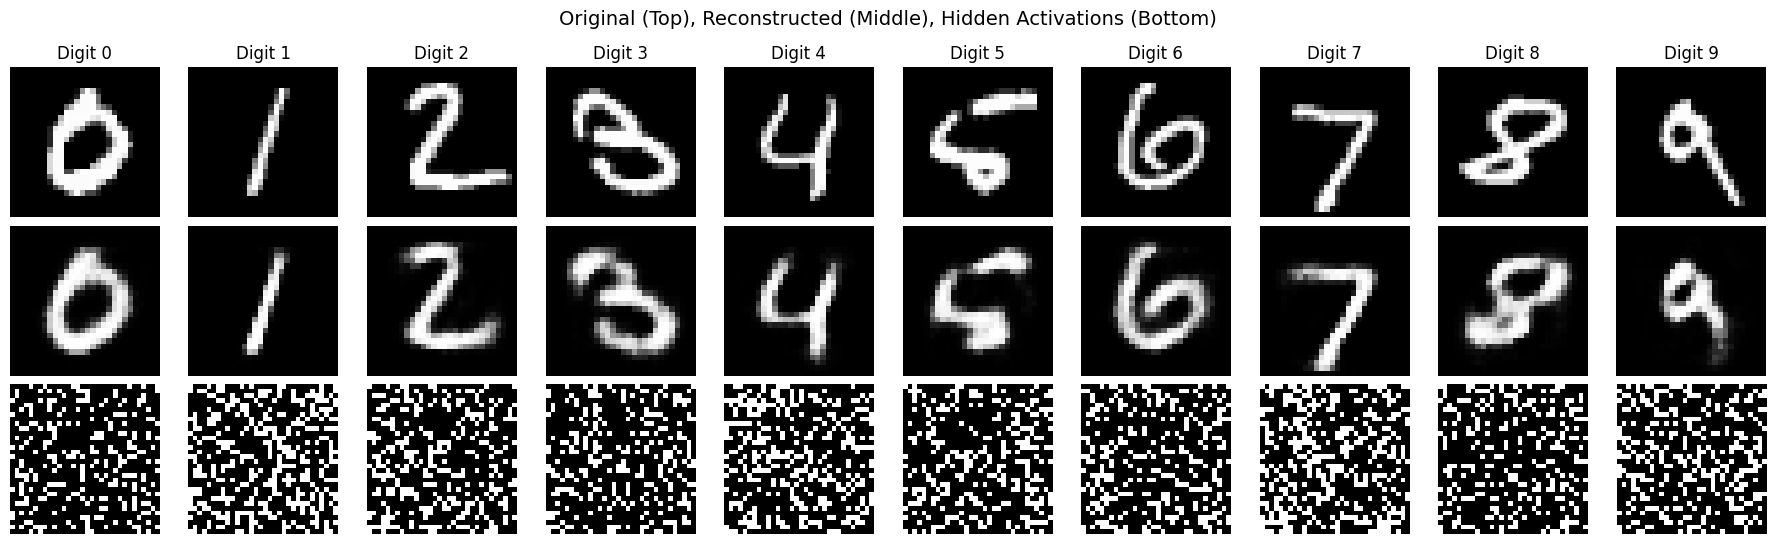

In [15]:
visualize_rbm_with_hidden_activations(rbm_k1, test_loader)

In [ ]:
Comment:


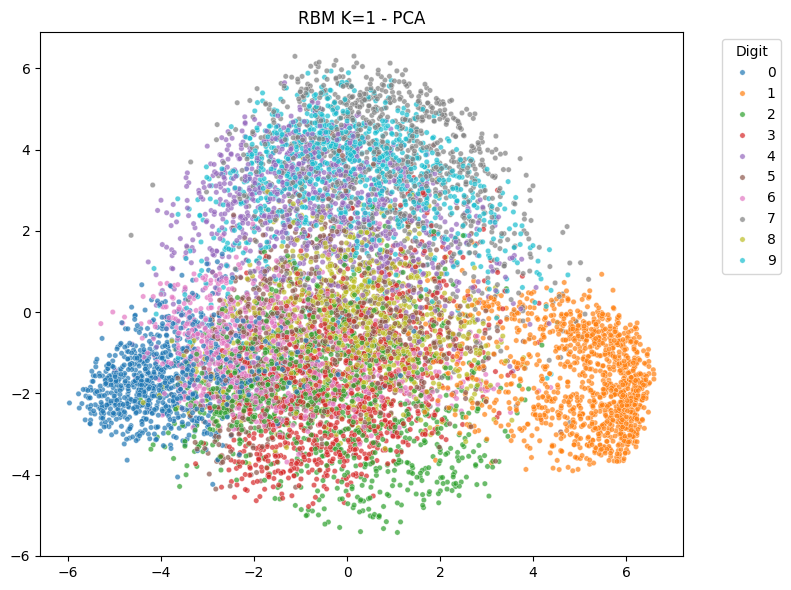

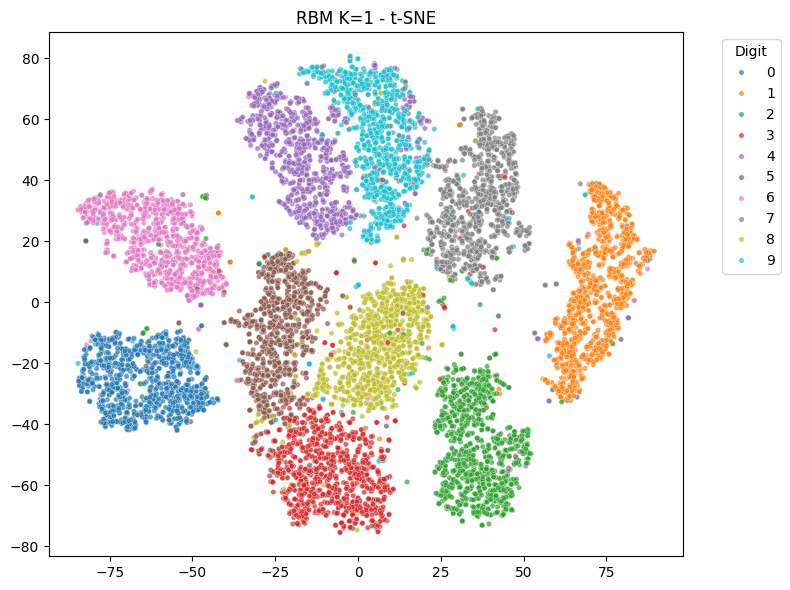

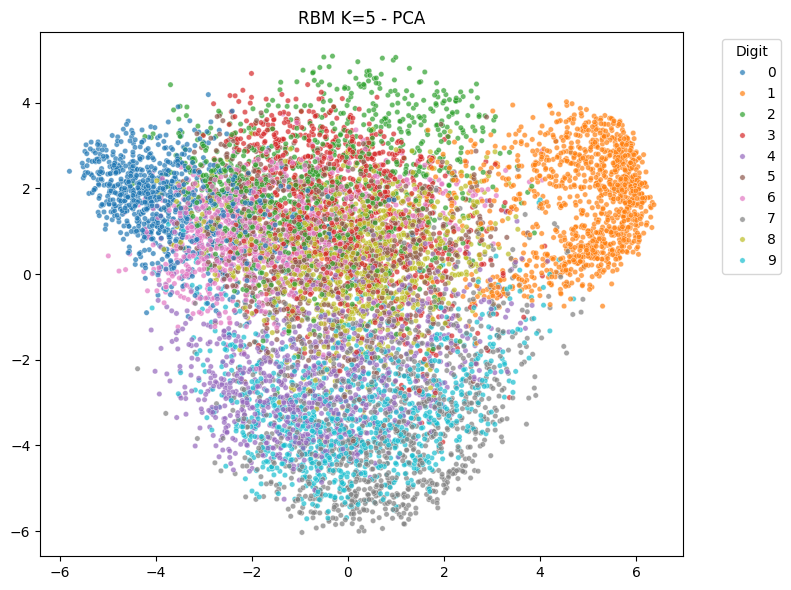

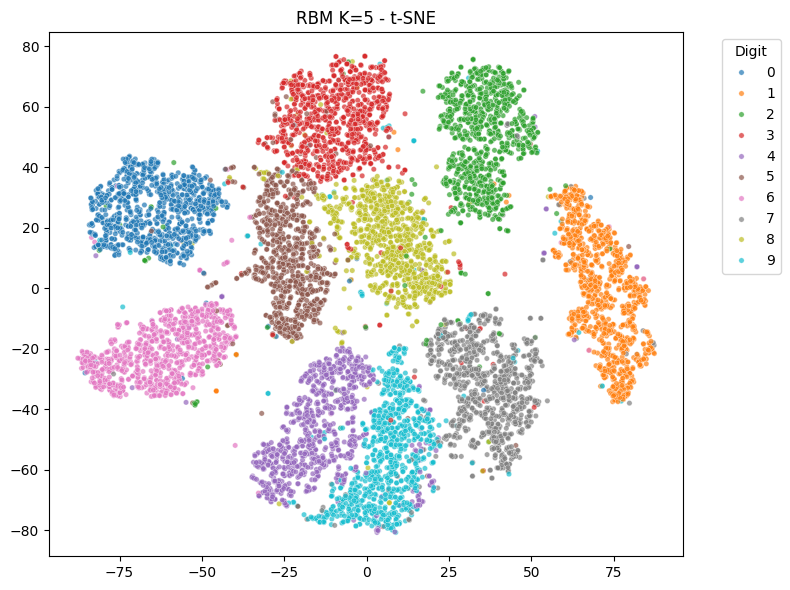

In [16]:
def plot_embedding(X, y, method='pca', title=''):
    if method == 'pca':
        reducer = PCA(n_components=2)
    elif method == 'tsne':
        reducer = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
    else:
        raise ValueError("Method must be 'pca' or 'tsne'")

    X_embedded = reducer.fit_transform(X)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=y, palette="tab10", s=15, alpha=0.7)
    plt.title(title)
    plt.legend(title='Digit', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


plot_embedding(X_test_k1, y_test_k1, method='pca', title='RBM K=1 - PCA')
plot_embedding(X_test_k1, y_test_k1, method='tsne', title='RBM K=1 - t-SNE')

plot_embedding(X_test_k5, y_test_k5, method='pca', title='RBM K=5 - PCA')
plot_embedding(X_test_k5, y_test_k5, method='tsne', title='RBM K=5 - t-SNE')

In [17]:
def visualize_denoising(rbm, test_loader, digit=2, steps=10, noise_level=0.4):
    # Step 1: Get one sample of the desired digit
    for image, label in test_loader:
        mask = (label == digit)
        if mask.any():
            original_img = image[mask][0].view(1, -1)
            break

    # Step 2: Binarize and add noise
    original_img = (original_img > 0.5).float()
    noisy_img = original_img.clone()
    noise = torch.bernoulli(torch.full_like(noisy_img, noise_level))
    noisy_img = (noisy_img + noise) % 2  # flip bits with probability = noise_level

    # Store reconstructions
    reconstructions = [noisy_img.view(28, 28).numpy()]
    v = noisy_img.clone()

    # Step 3: Perform multiple Gibbs steps
    for _ in range(steps):
        prob_h, h = rbm.sample_h(v)
        prob_v, v = rbm.sample_v(h)
        reconstructions.append(prob_v.view(28, 28).detach().numpy())

    # Step 4: Plot everything
    n_cols = steps + 2
    fig, ax = plt.subplots(1, n_cols, figsize=(2.5 * n_cols, 3))

    ax[0].imshow(original_img.view(28, 28).numpy(), cmap="gray")
    ax[0].set_title("Original")
    ax[0].axis('off')

    ax[1].imshow(reconstructions[0], cmap="gray")
    ax[1].set_title(f"Noisy (p={noise_level})")
    ax[1].axis('off')

    for i in range(1, steps + 1):
        ax[i + 1].imshow(reconstructions[i], cmap="gray")
        ax[i + 1].set_title(f"Step {i}")
        ax[i + 1].axis('off')

    plt.tight_layout()
    plt.show()

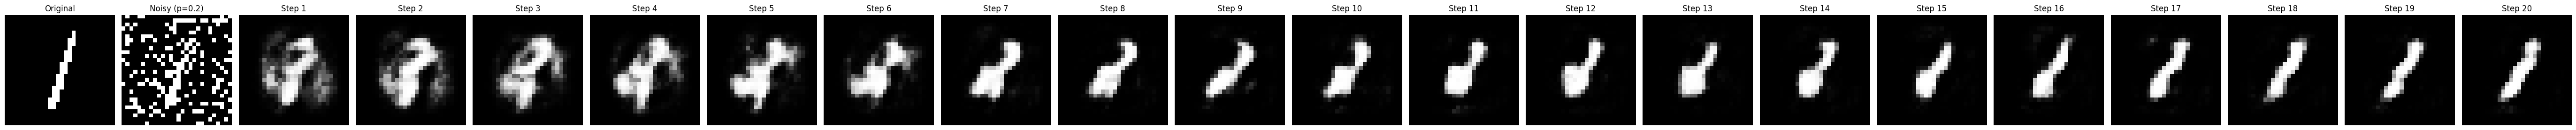

In [30]:
visualize_denoising(rbm_k5, test_loader, digit=1, steps=20, noise_level=0.2)


# Results

# Conclusions